# Visualize cumulative contibution by user over time for the [Deep Review](https://github.com/greenelab/deep-review)

Derived from [`rephetio-rviz.ipynb`](https://github.com/dhimmel/thinklytics/blob/ea8569e0e2aa5a15be34143b9a91fc4b3685c4cf/viz/rephetio-rviz.ipynb)

In [1]:
library(magrittr)

## Read datasets

In [2]:
commit_df = readr::read_tsv('commits.tsv') %>%
  dplyr::arrange(authored_datetime) %>%
  dplyr::filter(merge == 0) %>%
  dplyr::filter(characters_added != 0 | characters_deleted != 0) %>%
  dplyr::rename(username=author_name, date=authored_datetime)
  #dplyr::select(project, profile_id, username, first_name, last_name)
head(commit_df, 2)

Parsed with column specification:
cols(
  commit = col_character(),
  author_name = col_character(),
  author_email = col_character(),
  committer_name = col_character(),
  authored_datetime = col_datetime(format = ""),
  committed_datetime = col_datetime(format = ""),
  summary = col_character(),
  count = col_double(),
  merge = col_double(),
  parents = col_character(),
  words_added = col_double(),
  words_deleted = col_double(),
  characters_added = col_double(),
  characters_deleted = col_double()
)


commit,username,author_email,committer_name,date,committed_datetime,summary,count,merge,parents,words_added,words_deleted,characters_added,characters_deleted
cb3278723255f8f523e252163a626e4939880b74,Casey Greene,csgreene@upenn.edu,Casey Greene,2016-10-13 13:49:34,2016-10-13 13:49:34,add initial stub files,16,0,6f793ddbb15d865b6c20537e8691de03c7d7fda5,13,0,107,0
85d3e45c422952e7e6dcd5bc64f938df784579f6,Casey Greene,csgreene@upenn.edu,Casey Greene,2016-10-13 14:17:01,2016-10-13 14:17:01,fix up pandoc stubs,17,0,cb3278723255f8f523e252163a626e4939880b74,36,13,338,87


## Create a dataframe where each row is the cumulative contribution of a user at a given datetime

In [3]:
cumulative_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::mutate(cum_words = cumsum(words_added)) %>% 
  dplyr::mutate(cum_chars = cumsum(characters_added)) %>%
  dplyr::ungroup() %>%
  dplyr::select(username, date, cum_words, cum_chars)

cumulative_df %>% head(2)

username,date,cum_words,cum_chars
Casey Greene,2016-10-13 13:49:34,13,107
Casey Greene,2016-10-13 14:17:01,49,445


In [4]:
min_date = min(cumulative_df$date)
max_date = max(cumulative_df$date)

six_months = lubridate::duration(6, 'months')
even_date_df = dplyr::tibble(username = 'Anthony Gitter', date = seq(min_date - six_months, max_date + six_months, by='hours'))

cumulative_df = dplyr::bind_rows(
  cumulative_df %$%
    dplyr::tibble(username = unique(username), date=min_date - six_months, cum_words=0, cum_chars=0),
  cumulative_df,
  cumulative_df %>%
    dplyr::group_by(username) %>%
    dplyr::summarize(date=max_date + six_months, cum_words = max(cum_words), cum_chars = max(cum_chars))
  ) %>%
  dplyr::full_join(even_date_df) %>%
  tidyr::complete(username, date) %>%
  tidyr::fill(username, cum_words, cum_chars) %>%
  dplyr::filter(date %in% even_date_df$date)

cumulative_df %>% tail(2) 

Joining, by = c("username", "date")


username,date,cum_words,cum_chars
Zhiyong Lu,2018-09-04 23:49:34,959,7497
Zhiyong Lu,2018-09-05 00:49:34,959,7497


## Create a dataframe of users

In [5]:
# transformation = sqrt
transformation = identity

In [6]:
get_colors = colorRampPalette(RColorBrewer::brewer.pal(12, 'Paired'))

usage_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::summarize(
    first_date = min(date),
    total_chars = sum(characters_added),
    total_words = sum(words_added),
    total_chars_trans = transformation(total_chars)
  ) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(first_date) %>%
  dplyr::mutate(y_position = cumsum(total_chars_trans) - total_chars_trans / 2) %>%
  dplyr::mutate(color = get_colors(length(username)))

usage_df$username = factor(usage_df$username, levels = usage_df$username)

# If a user appears twice here, fix that manually in above
usage_df %>%
  dplyr::select(username, first_date, total_chars, total_words, color) %>%
  readr::write_tsv('contributors.tsv')

usage_df %>% head(3)

username,first_date,total_chars,total_words,total_chars_trans,y_position,color
Casey Greene,2016-10-13 13:49:34,80044,11152,80044,40022.0,#A6CEE3
Anthony Gitter,2016-10-24 20:32:10,80340,9793,80340,120214.0,#80B6D6
Gregory Way,2016-10-25 00:59:55,8809,1143,8809,164788.5,#5B9EC9


## Create a smoothed dataframe of cumulative contribution

In [7]:
min_date_decimal = min(commit_df$date) %>% lubridate::decimal_date()
max_date_decimal = max(commit_df$date) %>% lubridate::decimal_date()
constant = nrow(even_date_df) / diff(lubridate::decimal_date(range(even_date_df$date)))

densify = function(df) {
  den = suppressWarnings(density(
    df$date %>% lubridate::decimal_date(),
    weights = df$cum_chars, bw=0.025,
    from = min_date_decimal, to = max_date_decimal))
  dplyr::tibble(date = lubridate::date_decimal(den$x), cum_chars = den$y / constant) %>% return
}

smooth_df = cumulative_df %>%
  dplyr::group_by(username) %>%
  dplyr::do(densify(.)) %>%
  dplyr::mutate(cum_chars_trans = transformation(cum_chars)) %>%
  dplyr::ungroup()

smooth_df$username = factor(smooth_df$username, levels = usage_df$username)

smooth_df %<>% dplyr::arrange(username, date)
smooth_df %>% head(2)

username,date,cum_chars,cum_chars_trans
Casey Greene,2016-10-13 13:49:33,3042.610,3042.610
Casey Greene,2016-10-14 13:47:11,3338.079,3338.079


## Plot contribution over time

In [8]:
label_df = usage_df %>%
  dplyr::mutate(date = max_date) %>%
  dplyr::mutate(name_label = sprintf('- %s', username)) %>%
  dplyr::mutate(nchar_label = sprintf('%.1fK ', total_chars / 1000))

label_df %<>% dplyr::filter(total_chars >= 9000)
label_df %>% head(2)

username,first_date,total_chars,total_words,total_chars_trans,y_position,color,date,name_label,nchar_label
Casey Greene,2016-10-13 13:49:34,80044,11152,80044,40022,#A6CEE3,2018-03-06 13:17:34,- Casey Greene,80.0K
Anthony Gitter,2016-10-24 20:32:10,80340,9793,80340,120214,#80B6D6,2018-03-06 13:17:34,- Anthony Gitter,80.3K


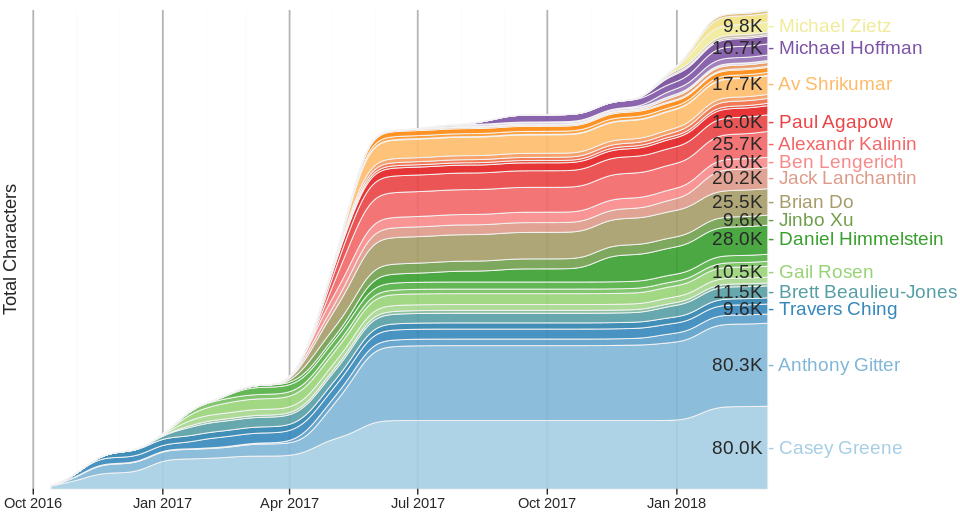

In [9]:
# Set figure dimensions
width = 8
height = 4.3
options(repr.plot.width=width, repr.plot.height=height)

major_breaks = seq(lubridate::make_datetime(2015, 1, 1), max_date, by = "3 months")
minor_breaks = seq(lubridate::make_datetime(2015, 1, 1), max_date, by = "1 months")
light_black = '#282828'

gg = smooth_df %>%
  ggplot2::ggplot(ggplot2::aes(x = date)) +
  ggplot2::geom_area(ggplot2::aes(y = cum_chars_trans, fill = username), 
            alpha = 0.9, size = 0.27, colour = "grey95",
            position=ggplot2::position_stack(reverse = TRUE)) +
  ggplot2::geom_text(data = label_df,
    mapping = ggplot2::aes(y = y_position, label=name_label, color=username), size = 4, hjust = 0) +
  ggplot2::geom_text(data = label_df,
    mapping = ggplot2::aes(y = y_position, label=nchar_label), size = 4, hjust = 1, color=light_black) +
  ggplot2::theme_minimal() +
  ggplot2::guides(colour = "none", fill = "none") +
  ggplot2::scale_x_datetime(date_labels = '%b %Y', breaks = major_breaks, minor_breaks = minor_breaks,
    limits = c(min_date - lubridate::period(1, 'day'), max_date + (max_date - min_date) / 4.92)) +
  ggplot2::scale_y_continuous(breaks = NULL, minor_breaks = NULL, labels = NULL, expand = c(0, 0)) +
  ggplot2::scale_fill_manual(values = usage_df$color) + 
  ggplot2::scale_color_manual(values = label_df$color) + 
  ggplot2::theme(
    axis.title.y = ggplot2::element_text(color = light_black, margin=ggplot2::margin(0,-9,0,0)),
    axis.ticks.x = ggplot2::element_line(size = 0.4, color = light_black),
    axis.text.x = ggplot2::element_text(color = light_black),
    axis.ticks.length = grid::unit(0.1, "cm"),
    panel.grid.major.x = ggplot2::element_line(colour = "grey70"),
    panel.grid.minor.x = ggplot2::element_line(colour = "grey98"),
    plot.margin = ggplot2::margin(t=6, r=2, b=2, l=2, unit='pt')) +
#  ggplot2::labs(x = NULL, y = expression(sqrt(Total~Characters)))
  ggplot2::labs(x = NULL, y = 'Total Characters')

gg

In [10]:
# Save image to file
ggplot2::ggsave(gg, filename = 'deep-review-contribution.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution.pdf', width = width, height = height, bg = 'transparent')

## Total words added ridgeline plot

In [11]:
total_words_stairstep <- function(df) {
  df = df %>% dplyr::transmute(x = date, y = words_added)
  init_df = dplyr::tibble(x = min(df$x), y = 0)
  stop_df = dplyr::tibble(x = max_date, y = 0)
  df = dplyr::bind_rows(init_df, df, stop_df) %>%
    dplyr::mutate(y = cumsum(y)) %>%
    ggplot2:::stairstep(direction="hv") %>%
    dplyr::distinct() %>%
    dplyr::rename(date = x, total_words = y)
  return(df)
}

total_words_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::do(total_words_stairstep(.)) %>%
  dplyr::ungroup()

total_words_df %>% head()

username,date,total_words
Aaron Sheldon,2017-05-16 03:27:41,0
Aaron Sheldon,2017-05-16 03:27:41,73
Aaron Sheldon,2018-03-06 13:17:34,73
Alexandr Kalinin,2017-04-21 18:29:50,0
Alexandr Kalinin,2017-04-21 18:29:50,118
Alexandr Kalinin,2017-04-28 11:12:24,118


In [12]:
y_labels = usage_df %$%
  sprintf('%s (+%s)', username, formatC(total_words, big.mark=',', format='d')) %>%
  setNames(usage_df$username)

usernames = as.character(usage_df$username)
usernames = c(usernames[1], '', usernames[2], '', usernames[3:nrow(usage_df)])

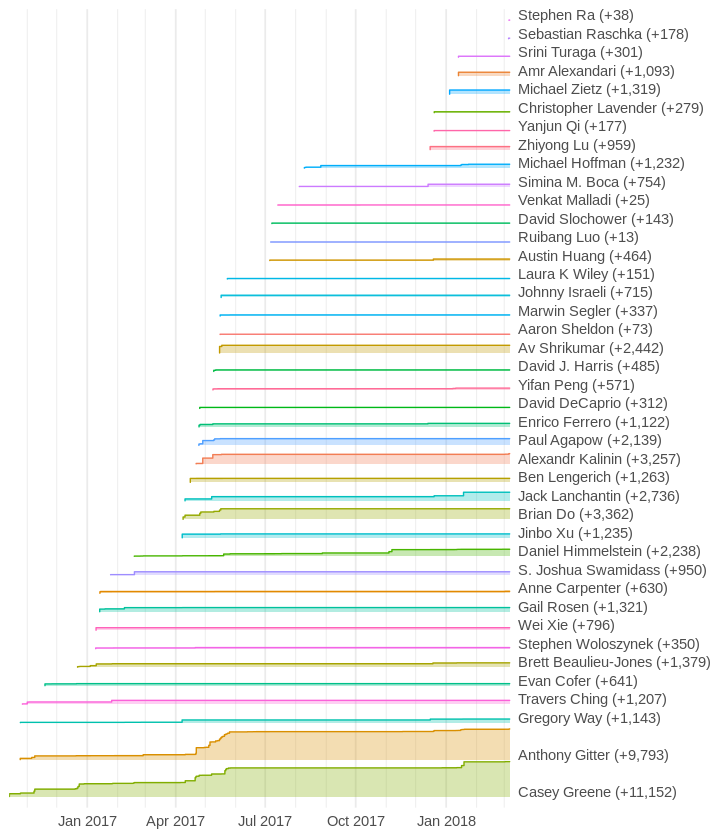

In [13]:
# Set figure dimensions
width = 6
height = 7
options(repr.plot.width=width, repr.plot.height=height)

gg = total_words_df %>%
  ggplot2::ggplot(ggplot2::aes(x = date, y = username, height = total_words, group = username, fill=username, color=username)) +
  ggridges::geom_density_ridges(stat='identity', size=0.4, alpha=0.3) +
  ggplot2::scale_x_datetime(expand = c(0, 0), date_labels = '%b %Y', breaks = major_breaks, minor_breaks = minor_breaks) +
  ggplot2::scale_y_discrete(limits=usernames, position = 'right', labels=y_labels) +
  #ggplot2::scale_fill_manual(values = setNames(usage_df$color, usage_df$username)) +
  ggplot2::guides(fill=FALSE, color=FALSE) +
  ggplot2::xlab(NULL) +
  ggplot2::ylab(NULL) +
  ggplot2::theme_minimal() +
  ggplot2::theme(axis.text.y = ggplot2::element_text(vjust = 0)) +
  ggplot2::theme(panel.grid.major.y = ggplot2::element_blank())

gg

In [14]:
# Save image to file
ggplot2::ggsave(gg, filename = 'deep-review-contribution-ridge.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution-ridge.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution-ridge.pdf', width = width, height = height, bg = 'transparent')

## Create a monthly commit summary dataframe

In [15]:
month_df = commit_df %>%
  dplyr::mutate(year_month=substr(date, 0, 7)) %>%
  tidyr::gather('diff_type', 'count', words_added:characters_deleted) %>%
  dplyr::group_by(username, year_month, diff_type) %>%
  dplyr::summarize(
    count = sum(count)
  ) %>%
  dplyr::ungroup()
month_df %>% head(3)

username,year_month,diff_type,count
Aaron Sheldon,2017-05,characters_added,545
Aaron Sheldon,2017-05,characters_deleted,408
Aaron Sheldon,2017-05,words_added,73


### Visualize contribution by month

In [16]:
# Create year_month breaks to gaurantee no missing months
`%m+%` = lubridate::`%m+%`
year_month_breaks = format(seq(min(commit_df$date), max(commit_df$date) %m+% months(1), by = "month"), "%Y-%m")


year_month_labeler = function(year_month) {
  # Function to return axis labels for every third year_month
  date_ = lubridate::ymd(year_month, truncated = 1)
  month_ = lubridate::month(date_)
  if (month_ %% 3 == 1) {
    return(format(date_, "%b %Y"))
  }
  return("")
}
year_month_labeler = Vectorize(year_month_labeler)

# diff_type colors
diff_type_colors = c(
  words_added = '#28A745',
  words_deleted = '#CB2431'
)

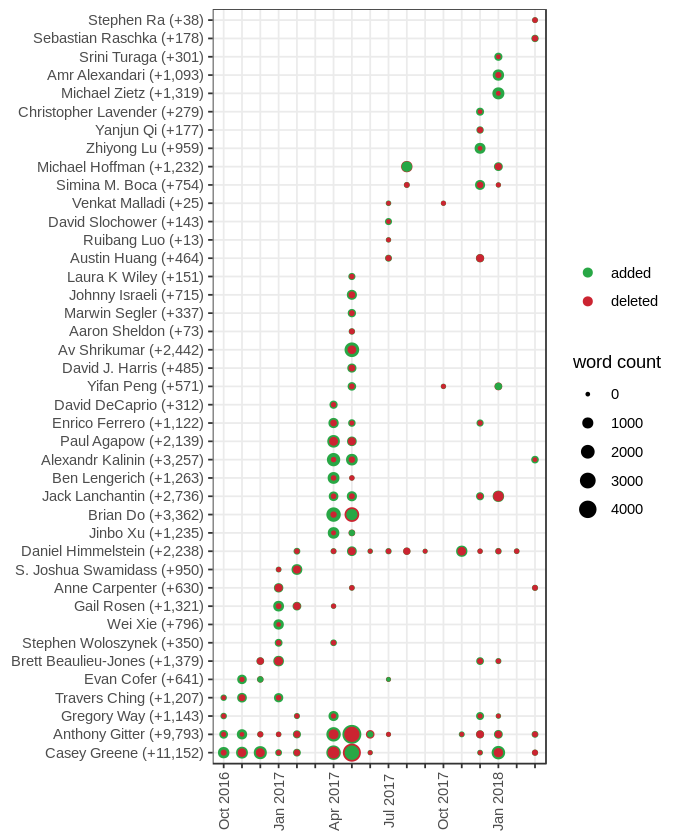

In [17]:
# Set figure dimensions
width = 5.7
height = 7
options(repr.plot.width=width, repr.plot.height=height)

gg = month_df %>%
  dplyr::filter(diff_type %in% c('words_added', 'words_deleted')) %>%
  dplyr::arrange(desc(count)) %>%
  #dplyr::arrange(desc(diff_type)) %>%
  ggplot2::ggplot(ggplot2::aes(x=year_month, y = username, size = count, color=diff_type)) +
  ggplot2::geom_point(stroke=1) +
  ggplot2::scale_y_discrete(limits=usage_df$username, position = 'top', labels=y_labels, name=NULL) +
  ggplot2::scale_x_discrete(limits = year_month_breaks, labels=year_month_labeler, name=NULL) +
  ggplot2::scale_size_area(max_size = 4, name='word count') +
  ggplot2::scale_color_manual(values=diff_type_colors, name=NULL, labels=c('added', 'deleted')) +
  ggplot2::coord_fixed() +
  ggplot2::theme_bw() +
  ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, vjust = 0.5))

gg

In [18]:
# Save image to file
ggplot2::ggsave(gg, filename = 'deep-review-contribution-dot.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution-dot.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution-dot.pdf', width = width, height = height, bg = 'transparent')

## Summary statistics

In [19]:
min_date
max_date
max_date - min_date

[1] "2016-10-13 13:49:34 UTC"

[1] "2018-03-06 13:17:34 UTC"

Time difference of 508.9778 days

## Package information

In [20]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/dhimmel/anaconda3/envs/contrib-viz/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] gdtools_0.1.7  bindrcpp_0.2.2 magrittr_1.5  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0         plyr_1.8.4         pillar_1.3.1       compiler_3.5.1    
 [5] RColorBrewer_1.1-2 bindr_0.1.1        base64enc_0.1-3    tools_3.5.1       
 [9] digest_0.6.18      uuid_0.1-2         js